This colab qualitatively and quantitatively evaluates segmentation results. It produces the predicted segmentations on the tune and test sets and visualizes them.

It then computes the Agatston coronary artery calcium scores from the ground truth and predicted segmentations, finds the best threshold from 0 to 1 on the tune set, and produces Agatston scores for the test sets.


In [ ]:
!pip install pydicom

import ast
import collections
import dataclasses
import datetime
import logging
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
import plistlib
import pydicom
import pytz
import sys
import tensorflow as tf
from matplotlib.path import Path
from scipy.ndimage import measurements
from tensorflow import keras
from typing import Dict, List, Optional, Text, Tuple
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

project_base_dir = ''
parsed_lesions_path = ''
gated_dir = ''
gt_agatston_file = ''

     |████████████████████████████████| 2.0 MB 5.0 MB/s 


In [ ]:
@dataclasses.dataclass
class Artery:
  name: Text
  class_index: int
  color: Text

@dataclasses.dataclass
class Lesion:
  points: List[Tuple[float, float]]
  artery: Text

@dataclasses.dataclass
class DicomAttributes:
  pixel_spacing: Optional[Tuple[float]]
  slice_thickness: Optional[float]
  rescale_intercept: Optional[float]
  rescale_slope: Optional[float]
  
@dataclasses.dataclass
class Slice:
  patient_id: Text
  image_path: Text 
  patient_split: Text
  has_calcification: bool
  lesions: List[Lesion]
  image: np.ndarray
  ground_truth_mask: np.ndarray
  dicom_attributes: DicomAttributes
  raw_image: np.ndarray
  ground_truth_agatston: Optional[float] = None
  predicted_agatston: Optional[float] = None
  predicted_mas: np.ndarray = None

ARTERIES = {'Right Coronary Artery': Artery(
                name='Right Coronary Artery',
                class_index=0,
                color='red',),
            'Left Anterior Descending Artery': Artery(
                name='Left Anterior Descending Artery',
                class_index=1,
                color='blue',),
            'Left Coronary Artery': Artery(
                name='Left Coronary Artery',
                class_index=2,
                color='green',),
            'Left Circumflex Artery': Artery(
                name='Left Circumflex artery',
                class_index=3,
                color='yellow',)
            }

In [ ]:
def read_parsed_lesions(parsed_lesions_path):
  BAD_PATIENT_IDS = set(
    [78, 120, 146, 3336, 3309])
  def maybe_literal_eval(x):
    try:
      return ast.literal_eval(x)
    except:
      return x

  with open(parsed_lesions_path, 'r') as f:
    df = pd.read_csv(f)
  bad_row_indices = df.loc[df.patient_id.isin(BAD_PATIENT_IDS)].index
  df = df.drop(index=bad_row_indices)
  df['lesion_points'] = df.lesion_points.apply(maybe_literal_eval)
  df = df.sample(frac=1, random_state=1216)
  return df

def read_csv(path):
  with open(path, 'r') as f:
    df = pd.read_csv(f)
  return df

def write_df(path, df):
  if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
  with open(path, 'w') as f:
    df.to_csv(f, index=False)
    print(f'Wrote file {path}')


df = read_parsed_lesions(parsed_lesions_path)
train_image_paths = list(df.loc[df.patient_split == 'train'].image_path.unique())
tune_image_paths = list(df.loc[df.patient_split == 'tune'].image_path.unique())
test_image_paths = list(df.loc[df.patient_split == 'test'].image_path.unique())

# Agatston calculations

In [ ]:
def get_object_agatston(calc_object: np.ndarray, calc_pixel_count: int):
  """Applies standard categorization: https://radiopaedia.org/articles/agatston-score"""
  object_max = np.max(calc_object)
  object_agatston = 0
  if 130 <= object_max < 200:
    object_agatston = calc_pixel_count * 1
  elif 200 <= object_max < 300:
    object_agatston = calc_pixel_count * 2
  elif 300 <= object_max < 400:
    object_agatston = calc_pixel_count * 3
  elif object_max >= 400:
    object_agatston = calc_pixel_count * 4
  # print(f'For {calc_pixel_count} with max {object_max} returning AG of {object_agatston}')
  return object_agatston

def compute_agatston_for_slice(example: Slice, predicted_mask: Optional[np.ndarray],
                               min_calc_object_pixels = 3) -> int:
  def create_hu_image(example: Slice):
    dicom_attributes = example.dicom_attributes
    if not dicom_attributes.rescale_slope or not dicom_attributes.rescale_intercept:
      raise ValueError(f'Cannot convert {example.image_path} to Hounsfield units.')
    return example.raw_image * dicom_attributes.rescale_slope + dicom_attributes.rescale_intercept
  if not predicted_mask is None:
    mask = predicted_mask
  else:
    mask = example.ground_truth_mask
  if np.sum(mask) == 0:
    return 0
  slice_agatston = 0
  dicom_attributes = example.dicom_attributes
  pixel_volume = (dicom_attributes.pixel_spacing[0] * dicom_attributes.pixel_spacing[1])
                 
  hu_image = create_hu_image(example)
  labeled_mask, num_labels = measurements.label(mask,
                                                structure=np.ones((3, 3)))
  for calc_idx in range(1, num_labels + 1):
    label = np.zeros(mask.shape)
    label[labeled_mask == calc_idx] = 1
    calc_object = hu_image * label

    calc_pixel_count = np.sum(label)
    # Remove small calcified objects.
    if calc_pixel_count <= min_calc_object_pixels:
      continue
    calc_volume = calc_pixel_count * pixel_volume
    object_agatston = round(get_object_agatston(calc_object, calc_volume))
    slice_agatston += object_agatston
  return slice_agatston


In [ ]:
def sample_images(df, split, num_positives, num_negatives, shuffle=False):
  if shuffle:
    df = df.sample(frac=1, random_state=1216)
  positives = df.loc[(df.patient_split == split) & (df.has_calcification==True)].image_path[0:num_positives]
  negatives = df.loc[(df.patient_split == split) & (df.has_calcification==False)].image_path[0:num_negatives]
  return pd.concat([positives, negatives])

# Load model

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-8):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  denom = K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f))
  dice = (2 * intersection + smooth) / (denom + smooth)
  return dice

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred):
  alpha = 0.55
  gamma = 2.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  focal = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.NONE,
                                              gamma=gamma,
                                              alpha=alpha)(y_true_f, y_pred_f)
  return K.sum(focal)

CUSTOM_OBJECTS = {'dice_loss': dice_loss, 'dice_coef': dice_coef, 'focal_loss': focal_loss}

SAVED_MODELS = {
  'upsample_dice_resume': '2021-11-26-01:58.upsample_dice_resume/08.hf5',
  'focal': '2021-11-27-02:37.final_unet_real_focal/11-28-01:31_step_11500.hf5',
  'focal_attention': '2021-11-29-00:09.attn_gate_focal/11-29-08:57_step_0.hf5',
}

def load_model(fname, project_base_dir, custom_objects=CUSTOM_OBJECTS):
  fpath = os.path.join(project_base_dir, 'checkpoints', fname)
  saved_model = keras.models.load_model(fpath, custom_objects=custom_objects)
  return saved_model

focal_attention_model = load_model(
    SAVED_MODELS['focal_attention'],
    project_base_dir
)


In [ ]:
focal_attention_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 512, 512, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_1_bn (BatchNormalization  (None, 512, 512, 32  128        ['conv1_1[0][0]']                
 )                              )                                                           

# Visualize Segmentations

In [ ]:
def plot_image_with_overlay(image_slice: Slice, prediction):
  image = image_slice.image
  ground_truth = image_slice.ground_truth_mask

  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(1, 5, 1)
  ax.set_title('Original image')
  ax.imshow(image, cmap='gray', interpolation=None)
  ax = fig.add_subplot(1, 5, 2)
  ax.set_title('Ground truth mask')
  ax.imshow(ground_truth, cmap='gray', interpolation=None)
  ax = fig.add_subplot(1, 5, 3)
  ax.set_title('Image with ground truth mask')
  ax.imshow(image, cmap='gray', interpolation=None)
  ax.imshow(ground_truth, cmap='gray', alpha=0.5, interpolation=None)
  ax = fig.add_subplot(1, 5, 4)
  ax.set_title('Predicted mask')
  ax.imshow(prediction, cmap='gray', interpolation=None)
  ax = fig.add_subplot(1, 5, 5)
  ax.set_title('Image with predicted mask')
  ax.imshow(image, cmap='gray', interpolation=None)
  ax.imshow(prediction, cmap='gray', alpha=0.5, interpolation=None)

def plot_image_slice(image_slice: Slice, prediction):
  plot_image_with_overlay(image_slice, prediction=prediction)

def get_prediction(saved_model, image, expand_dims=False):
  image = np.expand_dims(image, axis=0)
  if expand_dims:
    image = np.expand_dims(image, axis=3)
  prediction = saved_model(image, training=False).numpy()
  # prediction = (prediction > 0.5).astype(np.float32)
  return np.squeeze(prediction)

def eval_batch(saved_model, expand_dims, evaluation_image_paths, df, threshold):
  for image_path in evaluation_image_paths:
    print(image_path)
    image_df = df.loc[df.image_path == image_path]
    image_slice = load_single_example(image_path, image_df, gated_dir)
    prediction = get_prediction(saved_model, image_slice.image, expand_dims)
    if threshold:
      prediction = (prediction > threshold).astype(np.float32)
    print(f'prediction sum {np.sum(prediction)} and gt sum {np.sum(image_slice.ground_truth_mask)}')
    plot_image_slice(image_slice, prediction)
  
eval_image_paths = sample_images(df, 'test', num_positives=40, num_negatives=15, shuffle=True)
eval_batch(focal_attention_model,
           True,
           eval_image_paths,
           df,
           threshold=0.5)

# Define data generator

In [ ]:
def normalize_image(image: np.ndarray):
  """Normalize pixels to the range [0, 1]."""
  image_min = np.min(image)
  image_range = np.max(image) - image_min
  return ((image - image_min)/ image_range).astype(np.float32)
  # return image / np.max(image)

def create_mask(image: np.ndarray, lesions: List[Lesion]):
  height, width = image.shape
  if not lesions:
    return np.zeros((height, width), dtype=np.float32)
  all_bool_masks = []
  for lesion in lesions:
    lesion_points = [(p[1], p[0]) for p in lesion.points]
    poly_path = Path(lesion_points)
    x, y = np.mgrid[:height, :width]
    coordinates = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    bool_mask = poly_path.contains_points(coordinates).reshape(height, width)
    all_bool_masks.append(bool_mask)
  out_mask = np.zeros((height, width))
  for mask in all_bool_masks:
    out_mask += mask
  return out_mask.astype(np.float32)

def load_single_example(image_path, image_df, gated_dir): 
  def get_dicom_attributes(dicom):
    raw_image = image
    pixel_spacing = None
    slice_thickness = None
    rescale_intercept = None
    rescale_slope = None
    try:
      rescale_slope = float(dicom.get('RescaleSlope'))
      rescale_intercept = float(dicom.get('RescaleIntercept'))
      slice_thickness = float(dicom.get('SliceThickness'))
      pixel_spacing = dicom.get('PixelSpacing')
      pixel_spacing = [(float(ps[0]), float(ps[1])) for ps in pixel_spacing]
    except:
      logging.error(f'Image {image_path} is missing dicom attribute(s).')
    return DicomAttributes(
        pixel_spacing = pixel_spacing,
        rescale_intercept = rescale_intercept,
        rescale_slope = rescale_slope,
        slice_thickness = slice_thickness,
    )

  assert image_df.image_path.nunique() == 1
  full_image_path = os.path.join(gated_dir, image_path[1:])
  dicom = pydicom.dcmread(full_image_path)
  image = dicom.pixel_array
  raw_image = image
  image = normalize_image(image)
  dicom_attributes = get_dicom_attributes(dicom)
  lesions = []
  for _, lesion_row in image_df.iterrows():
    if isinstance(lesion_row.lesion_points, float):
      # No lesions for this image
      continue
    lesions.append(Lesion(
        artery=lesion_row.artery,
        points = lesion_row.lesion_points))
  mask = create_mask(image, lesions)
  assert image_df.patient_id.nunique() == 1
  assert image_df.patient_split.nunique() == 1, f'Patient {image_df.iloc[0].patient_id} in {image_df.patient_split.unique()}'
  assert image_df.has_calcification.nunique() == 1
  
  if np.isnan(image_df.iloc[0].image_agatston):
    ground_truth_agatston = None
  else:
    ground_truth_agatston = image_df.iloc[0].image_agatston
  return Slice(
      patient_id = image_df.iloc[0].patient_id,
      image_path = image_path,
      patient_split = image_df.iloc[0].patient_split,
      has_calcification = image_df.iloc[0].has_calcification,
      lesions = lesions,
      image = image,
      ground_truth_mask = mask,
      dicom_attributes = dicom_attributes,
      raw_image = raw_image, # TODO: delete
      ground_truth_agatston = ground_truth_agatston
  )

def load_example(image_path, df, gated_dir):
  image_df = df.loc[df.image_path == image_path]
  example = load_single_example(image_path, image_df, gated_dir)
  return example

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self,
               df: pd.DataFrame,
               name: Text,
               image_paths: List[Text],
               batch_size: int,
               gated_dir: Text,
               positive_upsample_factor,
               add_dim: bool = False):
    self.df = df
    self.name = name
    self.batch_size = batch_size
    self.gated_dir = gated_dir
    self.add_dim = add_dim
    if positive_upsample_factor:
      original_length = len(image_paths)
      positive_image_paths = set(df.loc[(df.image_path.isin(image_paths)) & (df.has_calcification == True)].image_path)
      upsampled_positive_image_paths = list(positive_image_paths) * positive_upsample_factor
      image_paths = image_paths + upsampled_positive_image_paths
      additional_images = len(image_paths)-original_length
      print(f'Added {additional_images} images from {len(positive_image_paths)} original positives')
    else:
      print(f'No upsampling for {name}')
    np.random.shuffle(image_paths)
    self.image_paths = image_paths
    
  def __len__(self):
    length = math.ceil(len(self.image_paths) / self.batch_size)
    print(f'For {self.name} datagen length is {length}')
    return length

  def _prepare_batch(self, df, gated_dir): # TODO: rename to batch_df
    X_list = []
    Y_list = []
    image_slices = []
    grouped_df = df.groupby('image_path')
    for i, (image_path, image_df) in enumerate(grouped_df):
      image_slice = load_single_example(image_path, image_df, gated_dir) 
      image_slices.append(image_slice)
      if self.add_dim:
        X_list.append(np.expand_dims(image_slice.image, axis=2))
      else:
        X_list.append(image_slice.image)
      Y_list.append(image_slice.ground_truth_mask)
    X = np.array(X_list)
    Y = np.array(Y_list)
    return X, Y, image_slices

  def __getitem__(self, idx):
    batch_image_paths = self.image_paths[idx * self.batch_size: (idx+1) * self.batch_size]
    batch_metadata_df = self.df[self.df.image_path.isin(batch_image_paths)]
    X, Y, image_slices = self._prepare_batch(batch_metadata_df, self.gated_dir)
    return X, Y, image_slices

  def on_epoch_end(self):
    np.random.shuffle(self.image_paths)

# Agatston with data generator

## Compute

In [ ]:
def compute_agatston_with_data_gen(
    model,
    data_generator: tf.keras.utils.Sequence,
    threshold,
    write_frequency_batches,
    write_dir,
    num_batches=None):
  """
    Args:
      num_batches: number of batches to process. 
  """
  record_columns = ['patient_id', 'image_path', 'image_predicted_agatston',
                    'image_gt_agatston']
  if num_batches:
    assert num_batches <= data_generator.__len__(), 'Requesting too many batches'
  else:
    num_batches = data_generator.__len__()
  agatston_records = []
  for batch_num in range(num_batches):
    print(f'Batch {batch_num}')
    batch_X, batch_Y, image_slices = data_generator.__getitem__(batch_num)
    batch_predictions = model.predict_on_batch(batch_X)
    batch_predictions = np.squeeze(batch_predictions)
    if len(batch_predictions.shape) == 2:
      batch_predictions = np.expand_dims(batch_predictions, axis=0)
    assert len(batch_predictions.shape) == 3, 'Expected [batch_size, 512, 512] predictions'
    for i in range(batch_predictions.shape[0]):
      image_slice = image_slices[i]
      prediction = batch_predictions[i, :, :]
      image_slices[i].predicted_mask = prediction
      prediction = (prediction > threshold).astype(np.float32)
      predicted_agatston = compute_agatston_for_slice(image_slices[i],
                                            predicted_mask=prediction)
      image_slices[i].predicted_agatston = predicted_agatston
      ground_truth_agatston = compute_agatston_for_slice(image_slices[i],
                                                         predicted_mask=None)
      image_slices[i].ground_truth_agatston = ground_truth_agatston
      agatston_record = (image_slices[i].patient_id,
                         image_slices[i].image_path,
                         predicted_agatston,
                         image_slices[i].ground_truth_agatston)
      agatston_records.append(agatston_record)
    if batch_num % write_frequency_batches == 0:
      fname = os.path.join(write_dir, f'agatston_{batch_num}.csv')
      write_df(fname, pd.DataFrame.from_records(agatston_records,
                            columns=record_columns))
  agatston_df = pd.DataFrame.from_records(agatston_records,
                            columns=record_columns)
  return agatston_df=

def run_agatston(model,
                 df,
                 image_paths,
                 batch_size,
                 num_images,
                 threshold,
                 write_frequency_batches: int,
                 write_dir: Text,
                 name: Text = ''):
  if not os.path.exists(write_dir):
    os.makedirs(write_dir)
  data_gen = DataGenerator(
    df,
    name=name,
    image_paths=image_paths,
    batch_size=batch_size,
    gated_dir=gated_dir,
    positive_upsample_factor=0)
  if num_images:
    num_batches = math.ceil(num_images / batch_size)
  else:
    num_batches = None
  out = compute_agatston_with_data_gen(
    model=model,
    data_generator=data_gen,
    threshold=threshold,
    num_batches=num_batches,
    write_frequency_batches=write_frequency_batches,
    write_dir=write_dir,
    )
  return out

write_dir = os.path.join(project_base_dir, 'agatston', 'focal_model')

out = run_agatston(
    model=focal_model,
    df=df,
    image_paths=test_image_paths,
    batch_size=32,
    num_images = None,
    threshold=0.76,
    write_frequency_batches=20,
    write_dir = write_dir,
)

  


## Get volume-level score

In [ ]:
volume_gt = fixed_ag.groupby('patient_id').agg(lambda x: x.image_gt_agatston.sum()).image_gt_agatston

# Find best threshold

In [ ]:
positive_tune_image_paths = list(df.loc[(df.patient_split == 'tune') & (df.has_calcification == True)].image_path.unique())
positive_test_image_paths = list(df.loc[(df.patient_split == 'test') & (df.has_calcification == True)].image_path.unique())

def verify_df(df, positive_image_paths):
  a = df.loc[df.image_path.isin(positive_image_paths)]
  assert len(a.loc[pd.isnull(a.image_agatston)]) == 0

verify_df(df, positive_tune_image_paths)
verify_df(df, positive_test_image_paths)

In [ ]:
example = load_example(positive_tune_image_paths[5], df, gated_dir)
input = np.expand_dims(example.image, axis=0)
example_prediction = upsample_dice_model.predict(input)
example_prediction = np.squeeze(example_prediction)
binarized_prediction = (example_prediction > 0.5).astype(np.float32)
compute_agatston_for_slice(example, predicted_mask = binarized_prediction)
                                              # predicted_mask=binarized_prediction)

4

In [ ]:
def select_threshold_with_data_gen(
    model,
    df,
    positives_data_generator: tf.keras.utils.Sequence,
    num_batches,
    thresholds):
  """
    Args:
      df: parsed_lesions_with_gt_ag
      positives_data_generator: Produces positive examples only.
      num_batches: number of batches to process. 
  """
  assert num_batches <= positives_data_generator.__len__(), 'Requesting too many batches'
  agatston_records = []
  # Maps from each threshold to a list of MSEs encountered for it
  threshold_to_errors = collections.defaultdict(list)
  ag_history = collections.defaultdict(dict)
  for batch_num in range(num_batches):
    print(f'Processing batch {batch_num}')
    batch_X, batch_Y, image_slices = positives_data_generator.__getitem__(batch_num)
    batch_predictions = model.predict_on_batch(batch_X)
    batch_predictions = np.squeeze(batch_predictions)
    if len(batch_predictions.shape) != 3:
      # assert len(batch_predictions.shape) == 3, 'Expected [batch_size, 512, 512] predictions'
      print(f'Unexpected shape of {batch_predictions.shape}')
      continue
    for threshold in thresholds:
      for i in range(batch_predictions.shape[0]):
        prediction = batch_predictions[i, :, :]
        binarized_prediction = (prediction > threshold).astype(np.float32)
        predicted_agatston = compute_agatston_for_slice(image_slices[i], predicted_mask=binarized_prediction)
        image_slices[i].predicted_agatston = predicted_agatston
        ag_history[image_slices[i].image_path][threshold] = predicted_agatston
        # try:
        gt_agatston = image_slices[i].ground_truth_agatston
        assert type(predicted_agatston) == int , f'Type is {type(predicted_agatston)}'
        diff = abs(predicted_agatston - gt_agatston)
        threshold_to_errors[str(threshold)].append(diff)  
  # agatston_df = pd.DataFrame.from_records(agatston_records,
                            # columns=['image_path', 'predicted_image_agatston', 'image_calc_pixel_count'])
  threshold_errors_df = pd.DataFrame(threshold_to_errors)
  return threshold_errors_df, ag_history


def select_threshold(model,
                     image_paths,
                     df,
                     num_images,
                     thresholds,
                     batch_size=32,
                     shuffle=True):
  if shuffle:
    np.random.shuffle(image_paths)
  num_batches = math.ceil(num_images / batch_size)
  data_gen = DataGenerator(
      df,
      name='',
      image_paths=image_paths,
      batch_size=batch_size,
      gated_dir=gated_dir,
      positive_upsample_factor=0,
  )
  thresholds_out = select_threshold_with_data_gen(
                    model,
                    df,
                    data_gen,
                    num_batches=num_batches,
                    thresholds=thresholds )
  return thresholds_out

ORIG_THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
FOCUSED_THRESHOLDS = [0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]
thresholds_out = select_threshold(
    model=focal_attention_model,
    image_paths=tune_image_paths,
    df=df,
    num_images=3902,
    thresholds=ORIG_THRESHOLDS,
)

threshold_history_fname = os.path.join(project_base_dir, 'agatston', 'focal_attention_threshold_errors.csv')
write_df(threshold_history_fname, thresholds_out[0])
ag_history_file = os.path.join(project_base_dir, 'agatston', 'focal_attention_ag_history.csv')
with open(ag_history_file, 'wb') as f:
  pickle.dump(thresholds_out[1], f)


In [ ]:
error_dict = collections.defaultdict(list) # Map from threshold to list of absolute error
gt_scores = gt_scores.set_index('image_path')
missing_count = 0
for image_path, thresholds_dict in ag_history.items():
  for threshold, predicted_score in thresholds_dict.items():
    if image_path not in gt_scores.index:
      missing_count += 1
      continue
    gt_score = gt_scores.loc[image_path].image_gt_agatston
    error_dict[str(threshold)].append(abs(gt_score - predicted_score))
errors_df = pd.DataFrame(error_dict)    

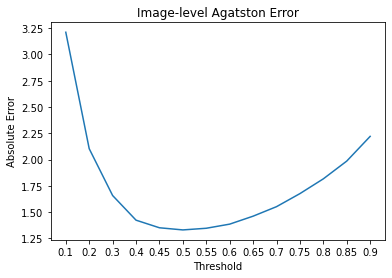

0.1     3.211002
0.2     2.103306
0.3     1.658058
0.4     1.423554
0.45    1.351240
0.5     1.330837
0.55    1.346591
0.6     1.385847
0.65    1.461519
0.7     1.551911
0.75    1.676136
0.8     1.816632
0.85    1.985537
0.9     2.220558
dtype: float64
Best threshold: 0.5 and MSE: 1.3308367768595042


In [ ]:
get_threshold(errors_df)

In [ ]:
def get_threshold(threshold_errors_df):
  mses = np.mean(threshold_errors_df)
  min_idx = mses.argmin()
  best_threshold = mses.index[min_idx]
  best_threshold_mse = mses.iloc[min_idx]
  plt.plot(list(mses.index), list(mses))
  plt.title('Image-level Agatston Error')
  plt.xlabel('Threshold')
  plt.ylabel('Absolute Error')
  plt.show()
  print(mses)
  print(f'Best threshold: {best_threshold} and MSE: {best_threshold_mse}')

# get_threshold(thresholds_out[0])

In [ ]:
df.sort_values(by='image_agatston', ascending=False)

(array([7.891e+03, 1.760e+02, 9.500e+01, 4.700e+01, 2.100e+01, 3.000e+00,
        5.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([   0. ,  176.2,  352.4,  528.6,  704.8,  881. , 1057.2, 1233.4,
        1409.6, 1585.8, 1762. ]),
 <a list of 10 Patch objects>)

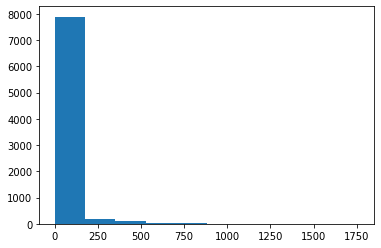

In [ ]:
plt.hist(list(df.image_agatston))